# Unidad 2: Preparación de los datos. Limpieza y preprocesamiento

El objetivo principal de esta práctica es que os familiaricéis con los conceptos y las aproximaciones clave para limpieza y preparación de los datos (preprocesado) para el desarrollo de modelos de Aprendizaje Automático (ML). Para ello,  la mayor parte del contenido se dedica a explicar estos aspectos,  apoyándose en ejemplos concretos que ilustran su aplicación a un problema real.  Es crucial que dediquéis tiempo a leer y comprender el material,  en lugar de simplemente ejecutar el código.  Os invitamos a experimentar modificando y variando el código proporcionado para que podáis explorar las distintas opciones y profundizar en su funcionamiento.


El Notebook contiene varios ejercicios sencillos. Debéis desarrollarlos durante la clase y enviarlos por el aula virtual de cada universidad.

## Referencias útiles para la práctica
1. API Pandas: [https://pandas.pydata.org/docs/reference/index.html](https://pandas.pydata.org/docs/reference/index.html)
2. API Scikit-learn: [https://scikit-learn.org/stable/api/index.html](https://scikit-learn.org/stable/api/index.html)
3. API Seaborn: [https://seaborn.pydata.org/api.html](https://seaborn.pydata.org/api.html)
4. Dataset para el ejercicio: [https://www.kaggle.com/datasets/camnugent/california-housing-prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)
5. Géron, Aurélien. Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.", 2022. 
   
## Flujo de trabajo básico en problemas de Aprendizaje Automático (*ML workflow*)
A la hora de enfrentarnos a un nuevo problema de Aprendizaje Automático (ML), existen una serie de pasos típicos y comunes que debemos afrontar:
1. Entender el problema y su contexto.
2. Obtener los datos (histórico).
3. Explorar, analizar y entender los datos.
4. Preparar los datos para los modelos.
5. Seleccionar, optimizar y entrenar los modelos ML.
6. Evaluar y presentar el modelo seleccionado.
7. Desplegar, monitorizar y mantener la solución.

En la Unidad 01 analizamos el problema y los datos disponibles. Solo ha sido una primera iteración y probablemente sea necesario "regresar" a esa etapa pero, por lo de pronto, prepararemos los datos para poder realizar un primer prototipo de modelo. Nos centraremos, por lo tanto, en el paso 4 del flujo de trabajo básico.

¿Qué operaciones haremos durante esta práctica?

* Limpieza y preprocesado:
    * Gestión de duplicados.
    * Eliminación de observaciones.
    * Gestión de datos faltantes o nulos (*data imputation*).
    * Discretización de variables.
    * Gestión de variables categóricas.
    * Escalado de las variables.
    * Transformación de la distribución de las variables.
* Desarrollo de un *pipeline* completo de limpieza y preprocesado.


## Carga de datos
Para dar continuidad a la unidad anterior, es necesario volver a cargar y asegurarse de repartir los datos en los mismos conjuntos (**repetibilidad**).



In [1]:
# Obtener los datos
# This package allows to directly download the  CSV from Kaggle
try:
    import kagglehub
except ImportError as err:
    !pip install kagglehub
    import kagglehub

# this library is only to improve the redability of some structures
# https://rich.readthedocs.io/en/stable/introduction.html
try:
    from rich import print
except ImportError as err:
    !pip install rich
    from rich import print

## pandas library
import pandas as pd
try:
    import pandas as pd
except ImportError as err:
    !pip install pandas
    import pandas as pd


# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")
print("Path to dataset files:", path)
#file name: housing.csv




dataset=pd.read_csv(path+"/housing.csv")#Carga datos desde un CSV y devuelve un DataFrame d
dataset.info()


Path to dataset files: /home/david/.cache/kagglehub/datasets/camnugent/california-housing-prices/versions/1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Datos duplicados
Si detectamos observaciones duplicadas y consideramos que son errores, deberíamos eliminarlas, ya que no queremos sobreentrenar los modelos con datos repetidos ni queremos influir a las métricas de Test con observaciones duplicadas.  Los DataFrame de Pandas tienen un método (<code>[duplicated()</code>](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)) para identificar filas duplicadas. En nuestro caso podemos comprobar que no tenemos dicho problema. Si existiese, Pandas nos proporciona un método para eliminarlos [<code>drop_duplicates</code>](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html).

In [2]:
print(f"Filas duplicadas: {dataset.duplicated().sum()}")

Filas duplicadas: 0

## División de los datos
Una vez definido definido el conjunto de datos que vamos a emplear, debemos ajustar los conjuntos de entrenamiento y test respetando el reparto de la Unidad 01. Durante la primera unidad, la analítica se realizó sobre el conjunto de entrenamiento y en esta segunda unidad, las operaciones de limpieza y preprocesado de los datos se desarrollarán pensando también en el conjunto de entrenamiento.

**Importante**: La división de datos debe realizarse sobre el conjunto de datos con exactamente las mismas observaciones. Si modificamos el conjunto, se modificarán los subconjuntos resultantes.

In [3]:
try:
    from sklearn.model_selection import train_test_split
except ImportError as err:
    !pip install sklearn
    from sklearn.model_selection import train_test_split
    
SEED=1234 #Semilla para asegurarnos que siempre se generen los mismos valores aleatorios
trainset, testset=train_test_split(dataset, test_size=0.3, train_size=0.7, random_state=SEED, shuffle=True, stratify=dataset["ocean_proximity"])

## Eliminación de observaciones

Durante el análisis de datos inicial en la Unidad 01, descubrimos que varias características tenían un límite superior. En particular, esto ocurría con la variable objetivo *median_house_value*. Esto puede ser un problema, ya que los modelos *aprenderían* que los inmuebles no pueden superar ese valor. Para el objetivo empresarial de nuestra empresa *Machine Learning Housing Corporation* eso sería un error, por lo que parece adecuado eliminar las observaciones asociadas a ese límite superior para evitar el problema con los modelos que desarrollemos. 

Esta operación no la realizamos antes para no influir en la división de los conjuntos, ya que modificaremos el número total de observaciones, pero es una modificación que debemos aplicar a todo el dataset, debido a que no queremos entrenar con esos datos pero tampoco testearlo contra ellos, para no desvirtuar las métricas. 

In [4]:
max_medianHouseValue=dataset["median_house_value"].max()

#Eliminación de observaciones de Entrenamiento
print(f"Número original de observaciones en el conjunto de entrenamiento: {len(trainset)}")
trainset=trainset[trainset["median_house_value"]!=max_medianHouseValue]
print(f"Número de observaciones en el conjunto de entrenamiento eliminadas las manzanas con límite superior: {len(trainset)}")

#Eliminación de observaciones de Test
print(f"Número original de observaciones en el conjunto de Test: {len(testset)}")
testset=testset[testset["median_house_value"]!=max_medianHouseValue]
print(f"Número de observaciones en el conjunto de Test eliminadas las manzanas con límite superior: {len(testset)}")


Número original de observaciones en el conjunto de entrenamiento: 14447

Número de observaciones en el conjunto de entrenamiento eliminadas las manzanas con límite superior: 13758

Número original de observaciones en el conjunto de Test: 6192

Número de observaciones en el conjunto de Test eliminadas las manzanas con límite superior: 5916

**IMPORTANTE**

Durante este Notebook vamos a ir viendo diferentes operaciones de limpieza y preprocesado de datos. Vamos a hacer los cálculos y análisis necesarios sobre el conjunto de entrenamiento y veremos el resultado de aplicarlo sobre ese conjunto PERO **no vamos a consolidar los cambios**. Al final del Notebook crearemos un *pipeline* de operaciones y las ejecutaremos todas juntas. El *pipeline* que generemos, será el que posteriormente usemos para aplicar las mismas operaciones sobre el conjunto de Test (o sobre cualquier otro).


## Gestión de nulos - *Data imputation*
### Observaciones con valores desconocidos
Trabajar con atributos de los que desconocemos el valor es un problema a la hora de desarrollar modelos, ya que la mayoría de ellos no son capaces de gestionarlos. Las estrategias más habituales para tratarlos son:

1. Eliminar todas las observaciones que contengan algún valor desconocido entre sus atributos.
    - Requiere tener una gran cantidad de datos, ya que podemos estar reduciendo los datos de forma significativa.
2. Eliminar las características que tienen valores desconocidos para todas las observaciones (manteniendo el resto).
    - Esta aproximación requiere que los valores desconocidos estén principalmente en ciertas características y que estas no tengan excesiva relevancia para el modelo.
3. Generar los valores desconocidos de forma estadística empleando, por ejemplo, la media, mediana, moda, etc. del atributo que contiene los nulos.
    - Dependerá del contexto del problema la medida estadística a emplear. Esta es una solución rápida y bastante habitual.
4. Generar los datos empleando otro modelo del ML que aprenda del resto del dataset.
    - Puede ser una solución interesante pero claramente es más compleja y requiere tiempo.
5. Asignarle un valor de forma directa.
    - Esta aproximación puede ser válida para asignar un valor que represente los valores desconocidos y así poder trabajar con ellos.
   
**Nota**: *Los alternativas 3,4 y 5 entran dentro de lo denominado como **Data Imputation**.*


**Importante**: La estrategia que se seleccione se aplicará sobre todos los datos PERO cualquier cálculo o decisión relacionado con *Data Imputation* se realizará sobre el conjunto de entrenamiento y se aplicará sobre el conjunto de Test sin analizar su contenido. Ejemplo: si decidimos usar la media para cubrir el valor de los atributos nulos, dicha media se calculará sobre el conjunto de entrenamiento y se aplicará sobre el conjunto de entrenamiento y sobre el de Test. **Los datos de Test nunca se emplearán para el cálculo**.


**Recordatorio**: En nuestro problema, solo la variable *total_bedrooms* contenía valores nulos. 



In [5]:
# Obtener los valores nulos 
#isnull genera una matriz de booleanos siendo True un nulo. 
#Los boleanos pueden interpretarse como enteros True=1, False=0
#La suma de un dataframe, por defecto, es por columnas
trainset.isnull().sum() 


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        145
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

**Alternativas para la gestión de nulos:**

**Nota**: probaremos las diferentes opciones sobre un dataset auxiliar para no modificar los datasets originales.

1. Eliminar **todas las observaciones** que contengan algún valor desconocido entre sus atributos.

In [6]:
#Esta alternativa se podría aplicar al conjunto completo, 
#ya que no requiere cálculos sobre los valores de las observaciones
#Genero un dataset nuevo con el resultado
trainset_sinnulos=trainset.dropna(subset="total_bedrooms")#devuelve un dataframe con las observaciones con nulos eliminadas
print(f"Observaciones del dataset original: {len(trainset)}. Número de atributos: {len(trainset.columns)}")
print(f"Observaciones del dataset modificado: {len(trainset_sinnulos)}. Número de atributos: {len(trainset_sinnulos.columns)}")
print("Valores nulos del dataset:")
trainset_sinnulos.isnull().sum() 

Observaciones del dataset original: 13758. Número de atributos: 10

Observaciones del dataset modificado: 13613. Número de atributos: 10

Valores nulos del dataset:

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

**Alternativas para la gestión de nulos:**

2. **Eliminar las características** que tienen valores desconocidos para todas las observaciones (manteniendo el resto).

In [7]:
#Esta alternativa se podría aplicar al conjunto completo, 
#ya que no requiere cálculos sobre los valores de las observaciones
#Genero un dataset nuevo con el resultado
#axis=1 significa que elimine columnas. axis=0 elimina filas

trainset_sinnulos=trainset.drop(labels="total_bedrooms", axis=1)#devuelve un dataframe con las columnas eliminadas

print(f"Observaciones del dataset original: {len(trainset)}. Número de atributos: {len(trainset.columns)}")
print(f"Observaciones del dataset modificado: {len(trainset_sinnulos)}. Número de atributos: {len(trainset_sinnulos.columns)}")
print("Valores nulos del dataset:")
trainset_sinnulos.isnull().sum() 

Observaciones del dataset original: 13758. Número de atributos: 10

Observaciones del dataset modificado: 13758. Número de atributos: 9

Valores nulos del dataset:

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

**Alternativas para la gestión de nulos** 

**Aproximaciones basadas en *Data Imputation***

3. Generar los valores desconocidos de forma estadística empleando, por ejemplo, la media, mediana, moda, etc. del atributo que contiene los nulos.

**Nota**: *Solo desarrollaremos la alternativa 3 como representante de las aproximaciones de *data imputation*.  La aproximación "5" es directa y la aproximación "4" implicaría el desarrollo de un modelo ML y aun no hemos llegado a este punto en las prácticas.*


 **Recordatorio**: Los cálculos o modelos para realizar este tipo de aproximaciones deben realizarse sobre el conjunto de entrenamiento. Nunca debéis emplear el conjunto de Test.



In [8]:
#calculo la mediana sobre el conjunto de test
mediana_total_bedrooms=trainset["total_bedrooms"].median()
print(f"Mediana de habitaciones por manzana: {mediana_total_bedrooms}")

#Aplico el valor de la mediana sobre los datos de entrenamiento
#Genero una copia del dataset porque no vamos a consolidar los cambios hasta el final
#El parámetro implace=true modifica el dataframe directamente
trainset_sinnulos=trainset.copy()
trainset_sinnulos["total_bedrooms"]=trainset["total_bedrooms"].fillna(mediana_total_bedrooms) #fillna() es un método del DataFrame
print(f"Observaciones del dataset de entrenamiento: {len(trainset)}. Número de atributos: {len(trainset.columns)}")
print(f"Observaciones del dataset modificado: {len(trainset_sinnulos)}. Número de atributos: {len(trainset_sinnulos.columns)}")
print("Valores nulos del dataset:")
print(trainset_sinnulos.isnull().sum() )

Mediana de habitaciones por manzana: 436.0

Observaciones del dataset de entrenamiento: 13758. Número de atributos: 10

Observaciones del dataset modificado: 13758. Número de atributos: 10

Valores nulos del dataset:

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

El uso de ***Data Imputation*** está bastante normalizado y, en nuestro caso, será la alternativa que utilicemos. En esta ocasión, en lugar de hacer los cálculos directamente, emplearemos un objeto de [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) de Scikit-Learn, ya que nos facilitará la integración de esta operación con un *pipeline* de preprocesado (último paso).

En este punto es importante que expliquemos el concepto de **estimador** ([*estimator*](https://scikit-learn.org/stable/glossary.html#term-estimator)) de Scikit-Learn. Los estimadores son objetos que pueden aprender de los datos y que contienen un método <code>fit()</code>. Existen un tipo especial de estimadores que se denominan **transformadores** (*transformer*) que pueden aprender sobre unos datos y transformar un dataset con la información aprendida a través del método <code>transform()</code>. Los transformadores tienen, además, un método que permite integrar las dos acciones directamente: <code>fit_transform()</code>. 

Un *SimpleImputer* es un estimador-transformador que puede aprender un estadístico (ej. mediana) y aplicarlo. Lo interesante es que la interfaz de un estimador es estándard y eso nos ayudará a componer *pipelines* usando la salida de un estimador como la entrada del siguiente.


**Importante**: No todas las estrategias valen para todos los tipos de atributos. Ej. No podemos calcular la media de un categórico pero si  la categoría más frecuente.


**Nota**: Scikit-learn dispone de *Imputers* mas avanzados como, por ejemplo,  [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) o [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html).


In [9]:
from sklearn.impute import SimpleImputer

#creamos un objeto de SimpleImputer. En el constructor definimos el estadístico a calcular.
dataimputer = SimpleImputer(strategy="median")

# Inicio Nota:
#trainset[["total_bedrooms"]] devuelve un DataFrame con una columna. Lo que necesita el SimpleImputer
#trainset["total_bedrooms"] devuelve una Serie de Pandas. 
# Fin Nota.


dataimputer.fit(trainset[["total_bedrooms"]])#fit permite aprender la media de los datos que se pasan al método

#Imprimimos el valor calculado sobre el dataset proporcionado
print(dataimputer.statistics_)

# generamos una copia del trainset para no modificar el original
trainset_sinnulos=trainset.copy()

# Imputa la media a los datos faltantes de un dataset empleando el método transform()
#Los datos imputados los escribimos en el dataset trainset_sinnulos
#Nota: el método de Sckit-Learn devuelve un array de numpy. 
trainset_sinnulos["total_bedrooms"]=dataimputer.transform(trainset_sinnulos[["total_bedrooms"]])


#ALTERNATIVA usando fit_transform
#trainset_sinnulos=trainset.copy()
#trainset_sinnulos["total_bedrooms"]=dataimputer.fit_transform(trainset_sinnulos[["total_bedrooms"]])

print(trainset_sinnulos.isnull().sum())


#SimpleImputer podría ser aplicado sobre cualquier nuevo conjunto
#imputando sus valores nulos con la media calculada sobre el conjunto de entrenamiento.


[436.]

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Discretización de variables


En algunas ocasiones puede ser interesante convertir valores continuos en valores discretos. La técnica consiste en agrupar diferentes subrangos numéricos en *discretizaciones* o *buckets*. 
- Ej. Atributo edad [0..100): menores (0-18) – adulto joven (18-35) – adulto (35-65) – senior (+65)

Con esta técnica estaríamos generando una variable categórica que puede ser de utilidad para el desarrollo de los modelos. 
En nuestro caso de estudio podríamos plantearnos si categorizar la edad del edificio puede mejorar el entrenamiento del modelo. ¿Podemos considerar que un edificio de 30 años es más barato que uno nuevo en la misma zona? 


Podemos establecer los grupos "a mano" empleando el método [<code>cut()</code>](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) de Pandas o emplear un transformador de Scikit-Learn como [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html).

Si nos fijamos en el histograma de la edad media de las edificaciones de cada manzana, veremos que tiene un límite superior en el que se agrupan todos los inmuebles de más de 50 años. Este dato es interesante y puede ayudarnos a decidir si aplicar la estrategia de categorización sobre dicha variable, ya que por defecto, ya tiene una *categoría* de más de 50.



<Axes: ylabel='Frequency'>

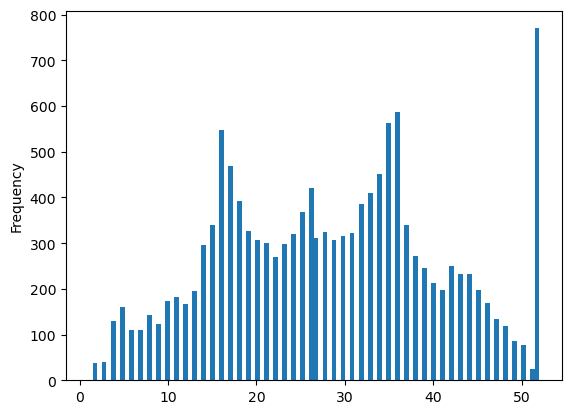

In [10]:
trainset["housing_median_age"].plot(kind="hist", bins=100)


Probaremos a repartir los valores en 4 categorías (representativas de los cuantiles). Recordad que los *transformadores* no devuelven un DataFrame. Tenemos que construirlo con la información que generan. 

El método <code>get_feature_names_out()</code> devuelve el nombre de las características empleadas para transformar. En este caso genera nombres para las nuevas características (una por cada categoría creada sobre la característica *housing_median_age*). Podremos usar dichos nombres para crear nuestro DataFrame.

La forma de codificar las categorías que se está generando es con la estrategia *one-hot encoding*. La descripción de esta estrategia se realiza en el siguiente paso de preprocesado (Transformación de las variables categóricas a numéricas).


In [11]:
from sklearn.preprocessing import KBinsDiscretizer

#creamos un objeto de la clase KBinsDiscretizer configurado para crear 4 bins en base a los cuantiles
discretizer=KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile')

#calculamos y aplicamos la discretización
aux=discretizer.fit_transform(trainset[["housing_median_age"]])
print(discretizer.get_feature_names_out())

#fit_transform() no devuelve un DataFrame.Tenemos que crearlo.
# Respetaremos el índice del conjunto de entrenamiento y los nombres usados en la transformación
housing_median_age_cat=pd.DataFrame(aux, columns=discretizer.get_feature_names_out(), index=trainset.index)


print(housing_median_age_cat.head())


['housing_median_age_0.0' 'housing_median_age_1.0'
 'housing_median_age_2.0' 'housing_median_age_3.0']

housing_median_age_0.0  housing_median_age_1.0  housing_median_age_2.0  \
4036                      0.0                     0.0                     0.0   
8629                      0.0                     0.0                     1.0   
7864                      0.0                     1.0                     0.0   
17458                     0.0                     1.0                     0.0   
6969                      0.0                     0.0                     0.0   

       housing_median_age_3.0  
4036                      1.0  
8629                      0.0  
7864                      0.0  
17458                     0.0  
6969                      1.0

## Gestión de variables categóricas
### Transformación de las variables categóricas a numéricas.


A menudo nos encontraremos con datasets con variables categóricas (como el caso *ocean_proximity*) pero, sin embargo, una buena parte de los modelos ML existentes están limitados a trabajar con variables numéricas, por lo que tendremos que transformar los valores categóricos a numéricos. Tenemos diferentes estrategias que deberemos evaluar de forma separada para decidir qué hacemos con cada atributo: 


* ¿Tiene sentido mantener esa característica? Si un atributo tiene una gran cantidad de posibles valores (ej. un nombre) tendremos que plantearnos si tiene sentido mantenerlo o si, simplemente, es mejor eliminarlo.
     - Para determinar si un atributo categórico es relevante para el modelo, podemos analizar su variabilidad. Si las categorías del atributo se repiten poco o son prácticamente constantes, es probable que no aporten valor predictivo y puedan ser eliminadas.
* Si un atributo solo tiene dos posibles categorías (binomial) solo necesitamos modificar el atributo para que sus dos valores sean representados por 1/0 (true/false).
* Asignar un número a cada posible categoría de un atributo  (***label encoding***).
   - **IMPORTANTE**: esta estrategia solo puede emplearse si las categorías tienen un orden entre ellas (ej. frío, templado, caliente). Si entre ellas no se puede asignar un orden (ej. rojo, verde, azul) entonces esta **aproximación es incorrecta** y debe gestionarse de otra forma (ej. *one-hot encoding*).
* Cuando trabajamos con valores categóricos que no tienen un orden intrínseco y el conjunto de posibles valores es limitado, podemos utilizar la técnica conocida como ***one-hot encoding***. Esta estrategia consiste en crear automáticamente una nueva variable para representar cada valor categórico posible de la característica original. Para cada observación, se asigna un valor de 1 a la nueva variable correspondiente si esa observación presenta el valor categórico en cuestión, mientras que las demás variables reciben un valor de 0. 


| ![encoding](img/encoding.png) | 
|:--:| 
| *Label encoding vs one-hot encoding. Fuente original: Wikipedia* |

. 



En el contexto de *Machine Learning Housing Corporation* y el atributo *ocean_proximity* parece que podríamos establecer un orden (distancia respecto al mar), aunque sería complicado establecer la prioridad entre "NEAR OCEAN" y "NEAR BAY".

**EJERCICIO**
- Utiliza la clase  [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) de Scikit-Learn para codificar el atributo *"ocean_proximity"* Genera una asignación entre categorías y números siguiendo la aproximación *label encoding*. 
- Por defecto, OrdinalEncoder asigna un número  por orden de aparición de la categoría. **Esto no es apropiado en nuestro caso**, ya que queremos establecer un orden concreto dependiendo de la cercanía al mar.
- Modifica el parámetro *categories* del constructor de [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) para configurar el siguiente orden: "ISLAND","NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"
- Imprime el resultado de ejecutar el método <code>fit_transform()</code>
- **Importante**: no modifiques el dataset de entrenamiento en el proceso. No asignes el resultado generado por <code>fit_transform()</code>.

    

In [12]:
### Ejercicio ###
# Utiliza la clase OrdinalEncoder de  Scikit-Learn para codificar el atributo "ocean_proximity"
#Genera una asignación entre categorías y números siguiendo la aproximación *label encoding*. 
# Por defecto, OrdinalEncoder asigna un número  por orden de aparición de la categoría. Esto no es apropiado en nuestro caso
# Modifica el parámetro "categories" para configurar el siguiente orden: "ISLAND","NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"
# Imprime el resultado de ejecutar el método fit_transform
# IMPORTANTE: no modifiques el dataset de entrenamiento en el proceso.
#No asignes el resultado generado por <fit_transform().





Aunque la estrategia de asignar directamente números a categorías podría ser válida en nuestro problema, debido al orden intrínsico de los posibles valores, la realidad es que la estrategia denominada *one-hot encoding* es la más habitual y es la que desarrollaremos en este caso para la versión final. Para realizar esta operación de preprocesado, emplearemos el *transformador* de Scikit-Learn [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

[OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) procesa un DataFrame y genera una matriz con tantas columnas como valores categóricos, en las que cada fila representa una observación y el cruce filas con columnas tiene el valor 1 si esa observación tiene ese valor categórico asociado o 0 en caso contrario.

Por defecto, el *transformador* OneHotEncoder genera una matriz de tipo *sparse* para ahorrar espacio, ya que típicamente será una matriz con multitud de columnas y filas en las que la mayoría de los valores serán cero. Para favorecer la comprensión del ejercicio, forzaremos a que devuelva una matriz densa (*sparse_output=False*)

El método <code>get_feature_names_out()</code> nos permite obtener los nombres de las columnas formadas por el nombre del atributo original y la categoría concreta analizada.

Fijaos que nuestro objeto OneHotEncoder queda "cargado" con la información, lo que luego nos permitirá aplicar el mismo procesado sobre el conjunto de Test o sobre cualquier otro.


Como siempre, el resultado del *transformador*, es un array de numpy, por lo que tendremos que construir un DataFrame con él, si es necesario.


In [13]:
from sklearn.preprocessing import OneHotEncoder

#sparse_output=False fuerza a que el resultado sea una matriz completa
encoder=OneHotEncoder(sparse_output=False)
encoded_ocean=encoder.fit_transform(trainset[["ocean_proximity"]])
print(encoder.get_feature_names_out())



# Crear un DataFrame con las columnas codificadas
encoded_ocean_df = pd.DataFrame(encoded_ocean,columns=encoder.get_feature_names_out(),index=trainset.index)
print(encoded_ocean_df.head())



['ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_ISLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
4036                         1.0                     0.0   
8629                         1.0                     0.0   
7864                         1.0                     0.0   
17458                        0.0                     0.0   
6969                         1.0                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
4036                      0.0                       0.0   
8629                      0.0                       0.0   
7864                      0.0                       0.0   
17458                     0.0                       0.0   
6969                      0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
4036                          0.0  
8629                          0.0  
7864                          0.0  
17458                         1.0  
6969                          0.0

**EJERCICIO**

Pandas contiene un método que permite hacer *one-hot encoding* de forma fácil y directa: [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html). 

Prueba el el código proporcionado (modifica y experimenta lo que consideres oportuni) y comenta en una celda del Notebook las razones por las que no deberíamos usar este método en nuestro proceso.

In [14]:
### EJERCICIO ###
#Analiza el API del método, prueba y modifica el siguiente código como consideres y
#explica las razones por las que consideras que este método puede no ser apropiado

#Primero codificamos el dataset de entrenamiento
print(trainset.columns)
cod_trainset=pd.get_dummies(trainset, columns=["ocean_proximity"])
print(cod_trainset.columns)
print(cod_trainset.head())

#Suponemos que en este punto entrenamos el modelo con los datos 

#Suponemos que nos llega un conjunto de Test en producción
test_nuevo=testset[0:2].copy()#solo tiene 2 observaciones

#procesamos el test_nuevo, para poder pasarlo al modelo que suponemos entrenado
cod_test_nuevo=pd.get_dummies(test_nuevo, columns=["ocean_proximity"])
print(cod_test_nuevo.columns)

# Aquí pasaríamos las observaciones de test al modelo
#¿Problemas?

#Imaginamos que nos llega en producción un nuevo subconjunto de test con una categoría nueva

test_nuevo2=testset[2:4].copy()
test_nuevo2.at[0,"ocean_proximity"]="Far away"
#Lo codificamos
cod_test_nuevo2=pd.get_dummies(test_nuevo2, columns=["ocean_proximity"])
print(cod_test_nuevo2.columns)
# Aquí pasaríamos las observaciones de test al modelo
#¿Problemas?



Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4036     -118.52     34.16                39.0       2693.0           478.0   
8629     -118.39     33.88                35.0       1267.0           216.0   
7864     -118.12     33.89                22.0       6876.0          1960.0   
17458    -119.86     34.42                23.0       1450.0           642.0   
6969     -118.05     33.98                41.0       1694.0           413.0   

       population  households  median_income  median_house_value  \
4036       1219.0       435.0         5.1700            335400.0   
8629        521.0       191.0         6.0441            470000.0   
7864       5162.0      1879.0         2.9293            170800.0   
17458      1258.0       607.0         1.1790            225000.0   
6969       1222.0       387.0         2.8311            155300.0   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
4036                        True                   False   
8629                        True                   False   
7864                        True                   False   
17458                      False                   False   
6969                        True                   False   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
4036                    False                     False   
8629                    False                     False   
7864                    False                     False   
17458                   False                     False   
6969                    False                     False   

       ocean_proximity_NEAR OCEAN  
4036                        False  
8629                        False  
7864                        False  
17458                        True  
6969                        False

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_Far away',
       'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY'],
      dtype='object')

**¿Observáis los problemas potenciales?**

Explica en esta celda las razones por las que el método <code>get_dummies()</code> puede no ser apropiado
#
#










## Escalado de las características

A menudo, en los problemas que tenemos que modelar, nos encontraremos con datasets que contienen atributos que están en escalas diferentes (ej. nº de habitaciones y precio de la vivienda), esto puede tener un impacto no despreciable en los modelos que entrenemos
(dependerá de lo sensible que sea el modelo escogido). Los modelos que tengan en cuenta distancias (KNN, SVM, etc.), emplean los atributos para calcular distancias entre observaciones y con eso determinan su similitud. Si gestionan características con escalas muy diferentes, pueden dar más peso a las características con valores más altos, distorsionando los resultados. 

Otro grupo de modelos en los que diferentes escalas pueden impactar en su rendimiento, son aquellos que emplean el descenso de gradiente para ajustar sus parámetros (ej. ANN, linear regression, etc.). En la fórmula que se usa para actualizar los pesos y que calcula el “paso” que se va a dar, aparece el valor del atributo ($x_j$). Si los atributos están en escalas muy diferentes, los pasos serán de tamaños diferentes dificultando la convergencia del modelo.


| $\Huge\theta_j:=\theta_j -\alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}-y^{i})x_j^{i})$| 
|:--:| 
| Gradiente descendente |


Por otro lado, existen otro tipo de modelos que son insensibles a las escalas y no requieren el escalado de las variables (aunque tampoco les perjudica) como, por ejemplo, los modelos basados en árboles.


Las dos alternativas más habituales para modificar la escala de los atributos son:

* **Normalización** (aka. *min-max scaling*): cambia (mapea) la escala de los datos a otra, típicamente entre 0 y 1, pero puede ser entre un valor ‘a’ y otro ‘b’. El problema es que requiere saber el valor mínimo y máximo posible para ese atributo en el momento de entrenar y esto no siempre es posible. Si tenéis un problema en el que desconocéis cómo evolucionará un atributo en producción, entonces no debéis usar este método (todos los valores que surjan por encima del que se detectó como máximo durante el entrenamiento, serán mapeados al mismo valor y pasará lo mismo con el mínimo).

| $\Huge X^´=a+\frac{(X-X_{min})(b-a)}{X_{max}-X_{min}}$| 
|:--:| 
| Fórmula para normalizar los datos entre los valores [a,b]|

* **Estandarización** (aka. *Z-Transformation*): es otro método de escalado en el que se transforman los valores para que estos estén centrados alrededor de la media con desviación típica 1. Se realiza en base a un dataset de entrenamiento en el que se calcula su media y su desviación típica y dichos valores se emplean para transformar los datos del conjunto a través de la fórmula mostrada en la siguiente tabla. Los valores de media y desviación típica calculados sobre el conjunto de entrenamiento se emplearán posteriormente para estandarizar los datos de Test. La ventaja de este método es que se puede emplear en producción, aunque los valores reales varíen con el tiempo. No se necesita conocer los máximos y mínimos de cada atributo como en el caso de la normalización.

| $\Huge X^´=\frac{X-\mu}{\sigma}$| 
|:--:| 
| Fórmula para estandarizar los datos generando un dataset con media 0 y desviación típica 1.|



Scikit-Llearn proporciona clases para escalar los datos a través de cualquiera de las aproximaciones mencionadas:

* Normalización:[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)
* Estandarización: [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  

**Nota**: El proceso de escalado solo tiene sentido en variables numéricas.

In [15]:
#Ejemplo con estandarización
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
#seleccionamos solo las variables numéricas para escalar
scaled_trainset=std_scaler.fit_transform(trainset.select_dtypes(include="number"))
print(scaled_trainset)

[[ 5.20393614e-01 -6.92953013e-01  8.47305528e-01 ... -1.69863966e-01
   9.63153097e-01  1.46277222e+00]
 [ 5.85187234e-01 -8.23175738e-01  5.26273646e-01 ... -8.03052109e-01
   1.52223281e+00  2.83991867e+00]
 [ 7.19758597e-01 -8.18524927e-01 -5.17079972e-01 ...  3.57736422e+00
  -4.70012335e-01 -2.21316231e-01]
 ...
 [ 6.30044355e-01 -7.90620057e-01  1.00782147e+00 ...  1.43834035e-02
  -1.54698112e+00 -9.37514236e-01]
 [-1.56297046e+00  1.23713380e+00 -1.15914374e+00 ...  1.40823660e-03
   3.40432579e-01  6.71884994e-01]
 [ 7.14774473e-01 -8.18524927e-01  3.65757705e-01 ...  8.94099717e-01
  -4.94765091e-01  1.27574511e-01]]

**EJERCICIO**

Repite el escalado pero esta vez aplica la normalización (aka min-max scaler).

In [16]:
#EJERCICIO
#Repite el escalado pero esta vez aplica la normalización (aka min-max scaler)


## Transformación de la distribución de las características

Si al analizar la distribución de una característica nos encontramos con un escenario en el que existe una "cola pesada" (*heavy tail*),es decir, cuando existe una gran asimetría y aparecen muchos valores alejados de la media, tanto la normalización como la estandarización comprimirán la mayoría de los valores en un rango pequeño y esto es algo con lo que los modelos de aprendizaje automático no trabajan bien. Existen diferentes métodos para intentar transformar los valores de las características buscando una mayor simetría.

Para características positivas con una "cola pesada" a la derecha, una aproximación común es remplazar el valor por su raíz cuadrada. Si la característica tiene una cola muy larga y pesada, entonces reemplazar los valores de la característica por su logaritmo puede ayudar.

Veamos un ejemplo con el caso de *population* en nuestro problema.

Valor máximo: 35682.0

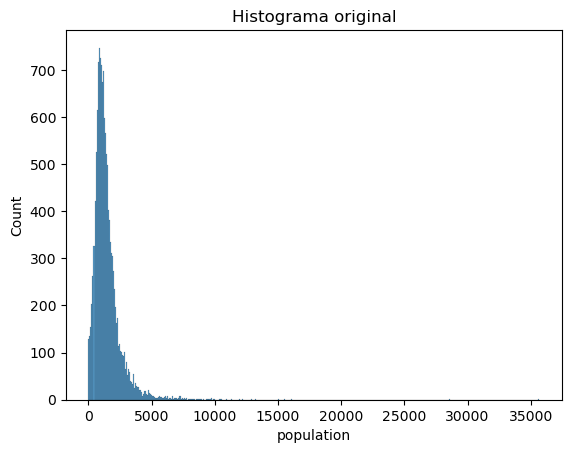

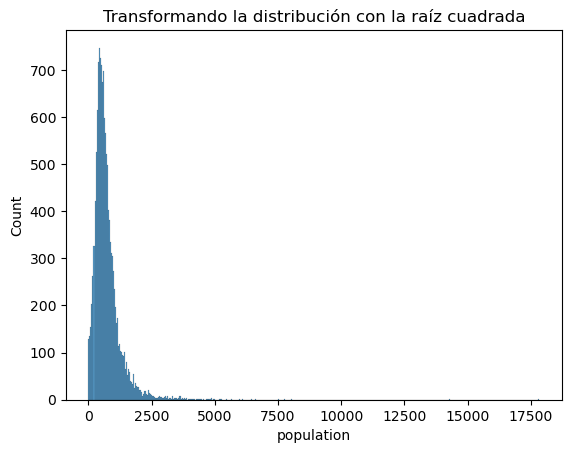

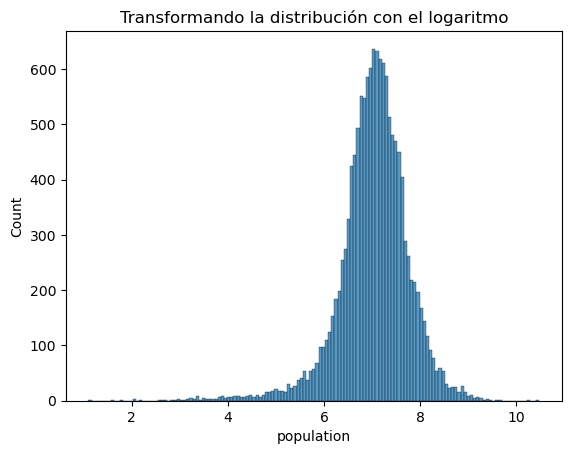

In [17]:
import seaborn as sns
import math
try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

print(f"Valor máximo: {trainset['population'].max()}")
sns.histplot(trainset['population']).set_title("Histograma original")
plt.show()
squared_trainset=trainset["population"]**1/2


sns.histplot(squared_trainset).set_title("Transformando la distribución con la raíz cuadrada")
plt.show()

log_trainset=trainset["population"].apply(math.log)

sns.histplot(log_trainset ).set_title("Transformando la distribución con el logaritmo")
plt.show()

Aplicando el logaritmo nos queda una forma más simétrica y apropiada para el desarrollo de los modelos.

Conforme a lo analizado en la Unidad 01, esta estrategia podría ser interesante para las siguientes características: 
- *total_rooms*.
- *total_bedrooms*.
- *population*.
- *households*.
- *median_income*.


La **discretización** de una variable es otra posible aproximación para gestionar distribuciones asimétricas con "colas pesadas".


### Uso de *transformadores* personalizados para el preprocesado

Scikit-Learn proporciona muchos e interesantes *transformadores* para poder limpiar y preprocesar nuestros datos pero también es posible crear nuestros propios *transformadores* a traves de [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)

¿Por qué es interesante? Nos va permitir integrar el proceso en un pipeline automático (lo veremos más adelante).

Veremos en el siguiente ejemplo como crear una *transformador* para aplicar la operación de logaritmo, que nos permita crear una distribución más simétrica para la variable de *population* (sección anterior) o cualquiera de las otras. **Fijaos** que se puede definir la operación inversa para recrear los datos originales.    



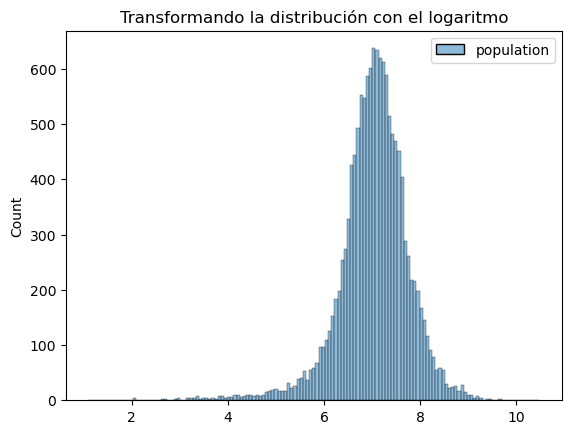

In [18]:
try:
    import numpy as np
except ImportError as err:
    !pip install numpy
    import numpy as np   
from sklearn.preprocessing import FunctionTransformer


log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_trainset = log_transformer.transform(trainset[["population"]])

sns.histplot(log_trainset).set_title("Transformando la distribución con el logaritmo")
plt.show()


## Ingeniería de variables

En esta fase nos enfocaríamos en crear nuevas caracterísiticas que pudiesen ayudar a los modelos. En este problema podríamos crear diferentes características. Algunas tan complejas como calcular la distancia de cada manzana a la ciudad grande más cercana, ya que vimos en la Unidad 01 que podía ser determinante. Por ahora nos centraremos en la creación de variables formadas a partir de la combinación de otras ya existentes, puesto que vimos en la Unidad 01 que tenían más correlación que las originales.

Recordemos los ratios que analizamos en la Unidad 01:
- $rooms\_per\_house=\frac{total\_rooms}{households}$.  Media de habitaciones por casa  
- $bedrooms\_ratio=\frac{total\_bedrooms}{total\_rooms}$. Ratio de dormitorios vs habitaciones
- $people\_per\_house=\frac{population}{households}$. Media de habitantes por casa

Para crear estas variables e integrar el proceso en el *pipeline* de limpieza y preprocesado, nos ayudaremos de los *transformadores* personalizados. Veremos cómo hacerlo de forma independiente, aunque en la versión final, que integremos en el *pipeline*, tendremos que hacer alguna variación para que se integren con el resto de *transformadores*. Los siguientes 3 ejemplos irán aumentando de complejidad hasta obtener un *transformador* genérico para el cálculo de ratios entre 2 variables cualesquiera.


**Importante**: La ingeniería de variables se ha presentado en este punto para poder integrala a través de los *FunctionTransformer* pero las variables generadas tienen que pasar por el mismo proceso que el resto como, por ejemplo, el escalado.

 




**Ejemplo 1**

FunctionTransformer para crear la variable $rooms\_per\_house$.
* <code>lambda X: X["total_rooms"] / X["households"]</code>: es una función anónima (lambda) que recibe un dataset $X$ y devuelve el ratio de 2 de sus columnas <code> X["total_rooms"] / X["households"]</code>



**Nota**: Las **funciones lambda** son funciones anónimas y compactas que se definen en una sola línea, ideales para operaciones simples. Se crean usando la palabra clave *lambda*, seguida de los parámetros, dos puntos, y una expresión. Las funciones se crean anónimas si consideramos que no van a tener más que un uso puntual.


In [19]:
#Creamos  la FunctionTransformer con la función que queremos aplicar
rooms_per_house_transformer=FunctionTransformer(lambda X: X["total_rooms"] / X["households"])

print(trainset[["total_rooms", "households"]].head())

#aplicamos la transformación
ratio=rooms_per_house_transformer.transform(trainset)

print(ratio[:5])

total_rooms  households
4036        2693.0       435.0
8629        1267.0       191.0
7864        6876.0      1879.0
17458       1450.0       607.0
6969        1694.0       387.0

4036     6.190805
8629     6.633508
7864     3.659393
17458    2.388797
6969     4.377261
dtype: float64

**Ejemplo 2**:

En el ejemplo anterior, creando una nueva variable, no tenemos control sobre el nombre que se le asigna. Si queremos incluir este proceso en un *pipeline*, necesitamos poder asignar un nombre automáticamente. Es posible asignar otra función *lambda* al parámetro *feature_names_out* con el objetivo de generar el nombre:
* El parámetro <code>feature_names_out</code> requiere un *callable* (función *lamda*) con dos argumentos: *self* y un array con los nombres de las características de entrada (*input_feature names*). Esos nombres los podemos emplear para generar el nombre de la nueva variable. Para acceder al nombre es necesario llamar al método <code>get_feature_names_out()</code> de nuestro objeto *FunctionTransformer* y pasarle una lista con las *inputs feature names*.

Al poder generar los nombres automáticamente y tener los valores de la nueva variable, podemos crear un DataFrame con el resultado.


  

In [20]:
#Creamos  la FunctionTransformer con la función que queremos aplicar
rooms_per_house_transformer=FunctionTransformer(lambda X: X["total_rooms"] / X["households"],
                                                feature_names_out=lambda self,input_names: [f"{input_names[0]}_ratio_{input_names[1]}"])

print(trainset[["total_rooms", "households"]].head())


#aplicamos la transformación
ratio=rooms_per_house_transformer.transform(trainset)
rooms_per_house_df=pd.DataFrame(ratio, 
                             columns=rooms_per_house_transformer.get_feature_names_out(["total_rooms","households"]),
                             index=trainset.index)

print(rooms_per_house_df.head())

total_rooms  households
4036        2693.0       435.0
8629        1267.0       191.0
7864        6876.0      1879.0
17458       1450.0       607.0
6969        1694.0       387.0

total_rooms_ratio_households
4036                       6.190805
8629                       6.633508
7864                       3.659393
17458                      2.388797
6969                       4.377261

**Ejemplo 3**:

Siguiendo el ejemplo 2, podríamos generar 3 *FunctionTransformer*, uno por cada nueva característica pero, teniendo en cuenta que las 3 se generan de la misma manera, es posible desarrollar un *FunctionTransformer* más general pensando en la integración con el *pipeline*.



**Nota**: En esta ocasión le asignaremos un nombre a las funciones, ya que no es obligatorio que sean anónimas. Tal y como se comentó anteriormente, lo normal es generarlas anónimas si van a tener un uso puntual y son muy simples (ej. 1 línea). 


**Importante**: en el siguiente ejemplo construimos una aproximación general teniendo en cuenta que estamos trabajando con DataFrames y es lo que recibimos como *input*. Cuando integremos estos transformadores en el *pipeline* final y se genere un flujo en el que las salidas de unos son las entradas de los siguientes,  tendremos que variarlo para que operan sobre arrays de numpy, ya que las funciones y métodos de Scikit-Learn generan no generan DataFrames. 

In [21]:
def column_ratio(X):
#accede a la primera columna del dataframe (0) y a la segunda (1) y devuelve el ratio
    return X.iloc[:,0] / X.iloc[:,1]
    
def ratio_name(function_transformer, feature_names_in):
# generamos el nombre empleando la información de las entradas
#Se espera que esta función devuelva un array de strings
    return [f"{feature_names_in[0]}_ratio_{feature_names_in[1]}"] 


#Creamos nuestro objeto FunctionTransformer
#La función para transformar es: column_ratio()
#La función para generar el nombre de la nueva característica es ratio_name()
ratio_transformer=FunctionTransformer(column_ratio,feature_names_out=ratio_name) # FunctionTransformer genérico para poder crear ratios



#aplicamos la transformación genérica y creamos un dataframe con los datos
people_per_house_df=pd.DataFrame(ratio_transformer.transform(trainset[["population", "households"]]), 
                             columns=ratio_transformer.get_feature_names_out(["population", "households"]),
                             index=trainset.index)

print(people_per_house_df.head())#Visualizamos las primeras filas del dataframe

#aplicamos la transformación genérica y creamos un dataframe con los datos
bedrooms_ratio_df=pd.DataFrame(ratio_transformer.transform(trainset[["total_bedrooms", "total_rooms"]]), 
                             columns=ratio_transformer.get_feature_names_out(["total_bedrooms", "total_rooms"]),
                             index=trainset.index)
print(bedrooms_ratio_df.head())#Visualizamos las primeras filas del dataframe


#aplicamos la transformación genérica y creamos un dataframe con los datos
rooms_per_house_df=pd.DataFrame(ratio_transformer.transform(trainset[["total_rooms", "households"]]), 
                             columns=ratio_transformer.get_feature_names_out(["total_rooms", "households"]),
                             index=trainset.index)

print(rooms_per_house_df.head())#Visualizamos las primeras filas del dataframe



population_ratio_households
4036                      2.802299
8629                      2.727749
7864                      2.747206
17458                     2.072488
6969                      3.157623

total_bedrooms_ratio_total_rooms
4036                           0.177497
8629                           0.170481
7864                           0.285049
17458                          0.442759
6969                           0.243802

total_rooms_ratio_households
4036                       6.190805
8629                       6.633508
7864                       3.659393
17458                      2.388797
6969                       4.377261

## Desarrollo de un pipeline

Durante este Notebook hemos visto diferentes procesamientos que se pueden realizar sobre un dataset antes de empezar a entrenar los modelos. Estas operaciones no son las únicas y no todos los problemas requieren las mismas. El tratamiento de los datos (analítica, limpieza y preprocesado) es la fase que habitualmente más tiempo consume (tiempo de la persona especialista) en el desarrollo de modelos. Es importante dedicar el tiempo necesario porque los modelos que desarrollemos serán tan buenos como los datos que tengamos. **Modelos complejos o tiempo de entrenamiento no sustituye una buena preparación y limpieza de datos**.

Una vez hemos limpiado y preparado los datos, tendremos una serie de pasos que deben ser ejecutados en un orden concreto, primero sobre el conjunto de  entrenamiento y, posteriormente, sobre el conjunto de Test  ( o sobre los datos que recibamos una vez desplegado el modelo). 

Scikit-Learn proporciona una clase [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) que nos permitirá crear una secuencia de operadores y que nos ayudará a crear este flujo de operaciones.

#### Pipeline para gestionar características numéricas
Veamos un ejemplo sencillo del funcionamiento del *Pipeline* centrado en la imputación de datos (gestión de nulos) y una estandarización posterior para tratar con características numéricas:


In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
num_pipeline = Pipeline([("impute", SimpleImputer(strategy="median")),("standardize", StandardScaler())])
print(num_pipeline)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

El contructor de la clase Pipeline requiere una lista de pasos/operaciones. Cada paso es una tupla (nombre,[estimador](https://scikit-learn.org/stable/glossary.html#term-estimator)). Todos los estimadores incluidos en la lista de pasos, excepto el último, deben ser del tipo *transformador*, es decir, tienen que proporcionar el método <code>fit_transform()</code>. El último paso puede contener un estimador de cualquier tipo (incluyendo un *transformador*). El *nombre* en la tupla es la forma en que nombramos al paso/operación. Solo es necesario tener cuidado que no se repita y tener en cuenta que no puede contener dos guiones bajos ("__").

Si no queremos darles nombres a los pasos y que estos se generen automáticamente, también es posible emplear la función [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) que los generará por nosotros empleando el nombre de las clases de los *transformadores*. **Fijaos** que en este caso, los pasos/operaciones NO se pasan dentro de una lista de Python.

In [23]:
#los estiamdores se pasan separados por ",". No van dentro de una lista
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
print(num_pipeline)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

El objeto *pipeline* nos proporcionará los mismos métodos que el estimador final. Como en nuestro caso el último paso también es un *transformador*, el *pipeline* funcionará también como un *transformador*, por lo que podemos usar el método <code>fit_transform()</code>.

Aplicaremos esta *pipeline* solo a las características numéricas empleando <code>select_dtypes(include="number")</code>


**Recordad** que los métodos de Scikit-Learn no devuelven un DataFrame, por lo que tendremos que convertirlo nuevamente si queremos mostrarlo como un DataFrame

In [24]:

print(trainset.select_dtypes(include="number").head())
print(10*"-")

preprocessing_num_pipeline_df = pd.DataFrame(num_pipeline.fit_transform(trainset.select_dtypes(include="number")),
                                     columns=num_pipeline.get_feature_names_out(),
                                     index=trainset.index)
print(preprocessing_num_pipeline_df.head())

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4036     -118.52     34.16                39.0       2693.0           478.0   
8629     -118.39     33.88                35.0       1267.0           216.0   
7864     -118.12     33.89                22.0       6876.0          1960.0   
17458    -119.86     34.42                23.0       1450.0           642.0   
6969     -118.05     33.98                41.0       1694.0           413.0   

       population  households  median_income  median_house_value  
4036       1219.0       435.0         5.1700            335400.0  
8629        521.0       191.0         6.0441            470000.0  
7864       5162.0      1879.0         2.9293            170800.0  
17458      1258.0       607.0         1.1790            225000.0  
6969       1222.0       387.0         2.8311            155300.0

----------

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4036    0.520394 -0.692953            0.847306     0.037888       -0.140937   
8629    0.585187 -0.823176            0.526274    -0.616206       -0.763305   
7864    0.719759 -0.818525           -0.517080     1.956595        3.379477   
17458  -0.147479 -0.572032           -0.436822    -0.532266        0.248636   
6969    0.754647 -0.776668            1.007821    -0.420345       -0.295341   

       population  households  median_income  median_house_value  
4036    -0.191421   -0.169864       0.963153            1.462772  
8629    -0.792406   -0.803052       1.522233            2.839919  
7864     3.203545    3.577364      -0.470012           -0.221316  
17458   -0.157841    0.276482      -1.589515            0.333226  
6969    -0.188838   -0.294426      -0.532822           -0.379903

#### Pipeline para gestionar características categóricas
Las operaciones de limpieza y preprocesado de las características categóricas son diferentes que para las numéricas. Veamos ahora un ejemplo de la creación de un *pipeline* simple para trabajar con las características categóricas.


In [25]:
#Generamos el pipeline asociado a las características categóricas
from sklearn.preprocessing import OneHotEncoder

print(trainset.select_dtypes(include="object").head())#seleccionamos solo las características categóricas
#pipeline formado por:
#un SimpleImputer que introduce el valor más repetido en caso de existir un nulo
#Un codificador OneHotEncoder para convertir las categorías a números
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore",sparse_output=False))


preprocessing_cat_pipeline_df = pd.DataFrame(cat_pipeline.fit_transform(trainset.select_dtypes(include="object")),
                                     columns=cat_pipeline.get_feature_names_out(),
                                     index=trainset.index)
print(10*"-")
print(preprocessing_cat_pipeline_df.head())



ocean_proximity
4036        <1H OCEAN
8629        <1H OCEAN
7864        <1H OCEAN
17458      NEAR OCEAN
6969        <1H OCEAN

----------

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
4036                         1.0                     0.0   
8629                         1.0                     0.0   
7864                         1.0                     0.0   
17458                        0.0                     0.0   
6969                         1.0                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
4036                      0.0                       0.0   
8629                      0.0                       0.0   
7864                      0.0                       0.0   
17458                     0.0                       0.0   
6969                      0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
4036                          0.0  
8629                          0.0  
7864                          0.0  
17458                         1.0  
6969                          0.0

#### Pipeline para gestionar características numéricas y categóricas
Por ahora hemos tratado con las características numéricas y categóricas por separado. Sería más conveniente tener un "selector" capaz de gestionar los dos tipos y aplicar la parte del *pipeline*  oportuna en cada caso. 

Para poder gestionar qué operaciones aplicamos a qué características, Scikit-Learn proporciona la clase [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). Esta clase permite ejecutar determinadas operaciones sobre determinadas columnas de un DataFrame , por lo que podremos escoger cuáles se ejecutan sobre las características numéricas y cuáles sobre las categóricas. Veamos un ejemplo:

In [26]:
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

cat_attribs = ["ocean_proximity"] #generamos una lista con las características categóricas
num_attribs=trainset.columns.tolist()#generamos una lista con las características categóricas
num_attribs.remove("ocean_proximity") #Los atributos numéricos son todos menos ocean_proximity


#Generamos el pipeline asociado a las características numéricas
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
#Generamos el pipeline asociado a las características categóricas
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore",sparse_output=False))



#Creamos el ColumnTransformer en el que asociamos cada pipeline a las características concretas
#ColumnTransformer requiere una lista de tripletes (nombre, pipeline, lista_atributos)
preprocessing_selector_pipeline=ColumnTransformer( [("num", num_pipeline, num_attribs),
                                                    ("cat", cat_pipeline,cat_attribs )
                                                   ])

##También es posible usar "make_column_transformer" para evitar nombrar a los diferentes pipelines
##make_column_transformer NO recibe los pipelines dentro de una lista de Python.
#preprocessing_selector_pipeline=make_column_transformer( (num_pipeline, num_attribs),(cat_pipeline,cat_attribs ))



#ALTERNATIVA
#Se puede sustituir la lista de atributos por una función que selecciona TODOS los atributos de un determinado tipo
#para no tener que generar la lista a mano
#make_column_selector(dtype_include=np.number)
#preprocessing_selector=ColumnTransformer( [("num", num_pipeline, make_column_selector(dtype_include=np.number)),("cat", cat_pipeline, make_column_selector(dtype_include=object))])


preprocessing_cat_num_pipeline_df= pd.DataFrame(preprocessing_selector_pipeline.fit_transform(trainset), 
                                    columns=preprocessing_selector_pipeline.get_feature_names_out(),
                                    index=trainset.index)
print(preprocessing_cat_num_pipeline_df.head())




num__longitude  num__latitude  num__housing_median_age  \
4036         0.520394      -0.692953                 0.847306   
8629         0.585187      -0.823176                 0.526274   
7864         0.719759      -0.818525                -0.517080   
17458       -0.147479      -0.572032                -0.436822   
6969         0.754647      -0.776668                 1.007821   

       num__total_rooms  num__total_bedrooms  num__population  \
4036           0.037888            -0.140937        -0.191421   
8629          -0.616206            -0.763305        -0.792406   
7864           1.956595             3.379477         3.203545   
17458         -0.532266             0.248636        -0.157841   
6969          -0.420345            -0.295341        -0.188838   

       num__households  num__median_income  num__median_house_value  \
4036         -0.169864            0.963153                 1.462772   
8629         -0.803052            1.522233                 2.839919   
7864          3.577364           -0.470012                -0.221316   
17458         0.276482           -1.589515                 0.333226   
6969         -0.294426           -0.532822                -0.379903   

       cat__ocean_proximity_<1H OCEAN  cat__ocean_proximity_INLAND  \
4036                              1.0                          0.0   
8629                              1.0                          0.0   
7864                              1.0                          0.0   
17458                             0.0                          0.0   
6969                              1.0                          0.0   

       cat__ocean_proximity_ISLAND  cat__ocean_proximity_NEAR BAY  \
4036                           0.0                            0.0   
8629                           0.0                            0.0   
7864                           0.0                            0.0   
17458                          0.0                            0.0   
6969                           0.0                            0.0   

       cat__ocean_proximity_NEAR OCEAN  
4036                               0.0  
8629                               0.0  
7864                               0.0  
17458                              1.0  
6969                               0.0

## Desarrollo del  *Pipeline* final

Ahora lo que nos queda es hacer la composición del *pipeline* completo con todas las operaciones que hemos visto durante el Notebook. Lo primero que haremos es separar las salidas (*Outputs*) de las características de entrada (*Inputs*), ya que el procesamiento lo haremos sobre las entradas del modelo.






In [27]:
#Output para nuestro modelo
output=["median_house_value"]

#Inputs para nuestro modelo. Todas las características menos la de salida
inputs=trainset.columns.to_list()
inputs.remove(output[0])

#Creamos una copia de un dataframe para los valores de salida
trainset_output=trainset[output].copy()

#Creamos una copia de un dataframe para los valores de entrada
trainset_inputs=trainset[inputs].copy()


A continuación desarrollaremos el *pipeline* completo para limpiar y preprocesar las características de entrada al modelo. **Este proceso tiene una cierta complicación**. Prestad atención y preguntad lo que considereis necesario.

In [28]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np



#1. Operaciones necesarias para la creación de variables nuevas "rooms_per_house", "bedrooms_ratio", "people_per_house"
##a. Data Imputation
##b. Ingeniería de variables
##c. Escalado de variables

#Las siguientes funciones son una adaptación de las vistas anteriormente 
#para crear Transformers personalizados (FunctionTransformer)
#Las adaptaciones están centradas en la gestión de ndarrays en lugar de DataFrames
def column_ratio(X):
    #función para crear el ratio de 2 variables
    #Esta creación será parte de un pipeline y en ese flujo, los datos será un ndarray,
    #ya que las operaciones de Scikit-Learn no generan dataframes de forma natura
    return X[:, [0]] / X[:, [1]]


def ratio_name(function_transformer, feature_names_in):
    ##función para generar los nombres  con el FunctionTransformer
    return ["ratio"] # feature names out


#pipeline específico para crear las variables nuevas
ratio_pipeline= make_pipeline(SimpleImputer(strategy="median"),
                              FunctionTransformer(column_ratio,feature_names_out=ratio_name),
                              StandardScaler())


#pipeline específico para modificar las distribuciones empleando el logaritmo
log_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             FunctionTransformer(np.log, feature_names_out="one-to-one"),
                             StandardScaler())


#pipeline específico para gestionar la variable categórica ocean_proximity
#a. imputando la categoría más frecuente, en caso de existir nulos
#b. aplicando el OneHotEncoder para codificar las categorías
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore",sparse_output=False))


#pipeline específico para discretizar la antigüedad de las viviendas "housing_media_age"
discret_pipeline=make_pipeline(SimpleImputer(strategy="median"),
                               KBinsDiscretizer(n_bins=4,encode='onehot-dense', strategy='quantile'),
                               OneHotEncoder(handle_unknown="ignore",sparse_output=False)
                              )



#Usaremos ColumnTransformer para indicar qué pasos operaciones se aplican a qué características
#1. Operaciones para generar atributos nuevos con ratio_pipeline
#2. Operaciones para modificar la distribución 
#3. Operaciones para gestionar la variable categórica ocean_proximity
#4. Operaciones para discretizar la variable housing_median_age
full_pipeline_preprocessing = ColumnTransformer([("bedrooms", ratio_pipeline, ["total_bedrooms", "total_rooms"]),
                                   ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]),
                                   ("people_per_house", ratio_pipeline, ["population", "households"]),
                                   ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population","households", "median_income"]),
                                   ("cat", cat_pipeline, ["ocean_proximity"]),
                                  ("disc", discret_pipeline, ["housing_median_age"])
                                   
                                  ])



preprocesing_trainset_inputs_df = pd.DataFrame(full_pipeline_preprocessing.fit_transform(trainset_inputs), 
                                    columns=full_pipeline_preprocessing.get_feature_names_out(),
                                    index=trainset_inputs.index)


print(preprocesing_trainset_inputs_df.head())






bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
4036         -0.578871                0.406542                -0.026707   
8629         -0.683542                0.618392                -0.032940   
7864          1.025732               -0.804834                -0.031313   
17458         3.378642               -1.412863                -0.087727   
6969          0.410344               -0.461307                 0.003002   

       log__total_bedrooms  log__total_rooms  log__population  \
4036              0.161098          0.372802         0.097245   
8629             -0.928558         -0.625274        -1.045749   
7864              2.096815          1.613615         2.037957   
17458             0.565746         -0.446691         0.139591   
6969             -0.039407         -0.240817         0.100550   

       log__households  log__median_income  cat__ocean_proximity_<1H OCEAN  \
4036          0.127293            0.987302                             1.0   
8629         -0.992029            1.340140                             1.0   
7864          2.117074           -0.295913                             1.0   
17458         0.580398           -2.351592                             0.0   
6969         -0.031712           -0.372933                             1.0   

       cat__ocean_proximity_INLAND  ...  cat__ocean_proximity_NEAR BAY  \
4036                           0.0  ...                            0.0   
8629                           0.0  ...                            0.0   
7864                           0.0  ...                            0.0   
17458                          0.0  ...                            0.0   
6969                           0.0  ...                            0.0   

       cat__ocean_proximity_NEAR OCEAN  disc__housing_median_age_0.0_0.0  \
4036                               0.0                               1.0   
8629                               0.0                               1.0   
7864                               0.0                               1.0   
17458                              1.0                               1.0   
6969                               0.0                               1.0   

       disc__housing_median_age_0.0_1.0  disc__housing_median_age_1.0_0.0  \
4036                                0.0                               1.0   
8629                                0.0                               1.0   
7864                                0.0                               0.0   
17458                               0.0                               0.0   
6969                                0.0                               1.0   

       disc__housing_median_age_1.0_1.0  disc__housing_median_age_2.0_0.0  \
4036                                0.0                               1.0   
8629                                0.0                               0.0   
7864                                1.0                               1.0   
17458                               1.0                               1.0   
6969                                0.0                               1.0   

       disc__housing_median_age_2.0_1.0  disc__housing_median_age_3.0_0.0  \
4036                                0.0                               0.0   
8629                                1.0                               1.0   
7864                                0.0                               1.0   
17458                               0.0                               1.0   
6969                                0.0                               0.0   

       disc__housing_median_age_3.0_1.0  
4036                                1.0  
8629                                0.0  
7864                                0.0  
17458                               0.0  
6969                                1.0  

[5 rows x 21 columns]

### Aplicación del pipeline a otros datasets

Una vez tengamos entrenado un modelo, este siempre esperará el mismo tipo de entradas y generará el mismo tipo de salida. Si nos llega un nuevo conjunto de observaciones, tendremos que aplicar exactamente las mismas operaciones de limpieza y de preprocesado (en el mismo orden y con la misma configuración). La ventaja de tener todo estructurado en un *pipeline* es que podemos reutilizarlo para los nuevos conjuntos. 

**Importante**: cuándo usemos nuevamente el *pipeline* no podemos volver a configurarlo, tenemos que ejecutarlo con la configuración de entrenamiento, por lo que para ejecutarlo **NO** podemos usar el método <code>fit_transform()</code>, **tenemos que usar el método** <code>transform()</code>.

In [29]:
testset_inputs=testset[inputs].copy()
testset_output=testset[output].copy()

preprocesing_testset_inputs_df = pd.DataFrame(full_pipeline_preprocessing.transform(testset_inputs), 
                                    columns=full_pipeline_preprocessing.get_feature_names_out(),
                                    index=testset_inputs.index)


print(preprocesing_testset_inputs_df.head())



bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
16929         0.383782               -0.513909                 0.015866   
6264         -0.322496               -0.046187                 0.043730   
19933        -0.252522                0.329339                -0.000495   
440           0.178979               -0.335847                -0.059872   
20408        -1.440068                1.621661                 0.006673   

       log__total_bedrooms  log__total_rooms  log__population  \
16929             0.899770          0.675139         1.129165   
6264             -0.125064         -0.025652         0.268915   
19933             0.404973          0.454294         0.358121   
440              -0.168161         -0.278062        -0.381252   
20408            -0.597281          0.161688        -0.400280   

       log__households  log__median_income  cat__ocean_proximity_<1H OCEAN  \
16929         0.943900           -0.076241                             0.0   
6264         -0.056536            0.247356                             1.0   
19933         0.246924           -0.264898                             0.0   
440          -0.149084           -0.318620                             0.0   
20408        -0.557014            1.912997                             1.0   

       cat__ocean_proximity_INLAND  ...  cat__ocean_proximity_NEAR BAY  \
16929                          0.0  ...                            0.0   
6264                           0.0  ...                            0.0   
19933                          1.0  ...                            0.0   
440                            0.0  ...                            1.0   
20408                          0.0  ...                            0.0   

       cat__ocean_proximity_NEAR OCEAN  disc__housing_median_age_0.0_0.0  \
16929                              1.0                               1.0   
6264                               0.0                               1.0   
19933                              0.0                               0.0   
440                                0.0                               1.0   
20408                              0.0                               1.0   

       disc__housing_median_age_0.0_1.0  disc__housing_median_age_1.0_0.0  \
16929                               0.0                               1.0   
6264                                0.0                               1.0   
19933                               1.0                               1.0   
440                                 0.0                               1.0   
20408                               0.0                               0.0   

       disc__housing_median_age_1.0_1.0  disc__housing_median_age_2.0_0.0  \
16929                               0.0                               0.0   
6264                                0.0                               0.0   
19933                               0.0                               1.0   
440                                 0.0                               1.0   
20408                               1.0                               1.0   

       disc__housing_median_age_2.0_1.0  disc__housing_median_age_3.0_0.0  \
16929                               1.0                               1.0   
6264                                1.0                               1.0   
19933                               0.0                               1.0   
440                                 0.0                               0.0   
20408                               0.0                               1.0   

       disc__housing_median_age_3.0_1.0  
16929                               0.0  
6264                                0.0  
19933                               0.0  
440                                 1.0  
20408                               0.0  

[5 rows x 21 columns]

## Guardado los datos
Si queremos emplear los datos preprocesados en otra Unidad, es conveniente que salvemos el DataFrame modificado para su uso posterior.




In [30]:
#Guardado de las observaciones preprocesadas de entrenamiento (Inputs)
preprocesing_trainset_inputs_df.to_csv("./preprocessing_trainset_inputs.csv",index_label="idx")
#Guardado de las observaciones de entrenamiento (Outputs)
trainset_output.to_csv("./trainset_ouputs.csv",index_label="idx")

#Guardado de las observaciones preprocesadas de test (Inputs)
preprocesing_testset_inputs_df.to_csv("./preprocessing_testset_inputs.csv",index_label="idx")
testset_output.to_csv("./testset_outputs.csv",index_label="idx")


## Entrenamiento de los modelos

Hemos llegado al final de la unidad para la limpieza y preprocesamiento de datos. En este punto ya tenemos un dataset de entrenamiento preparado para entrenar un modelo. Recordad que los pasos de limpieza y preprocesado no tienen que ser siempre los mismos, dependen del problema y de las características. En esta unidad solo hemos visto algunos ejemplos, quedan muchas otras operaciones que se podrían realizar, pero es una primera aproximación para poder empezar a desarrollar modelos de aprendizaje automático
